In [73]:
!git clone https://github.com/Code-str8/customer-fraud-detection.git


fatal: destination path 'customer-fraud-detection' already exists and is not an empty directory.


In [74]:
%cd customer-fraud-detection


/content/drive/MyDrive/customer-fraud-detection/customer-fraud-detection


In [75]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
%cd /content/drive/MyDrive/customer-fraud-detection

/content/drive/MyDrive/customer-fraud-detection


## **Fraud Detection in Electricity and Gas Consumption**
## BUSINESS UNDERSTANDING
Detect fraudulent clients using historical billing data from STEG. Help STEG identify and prevent fraudulent activities to reduce losses.
Evaluation Metric is AUC (Area Under the Curve), which will assess how well the model distinguishes between fraudulent and non-fraudulent clients.

             HYPOTHESIS

Null Hypothesis (H0): The distribution of counter_type does not differ between fraudulent and non-fraudulent clients..


Alternative Hypothesis (H1): Certain counter_type values are more prevalent among fraudulent clients, indicating a relationship between counter type and fraudulent activities.

### QUESTIONS


1. How does counter_type distribution differ between fraudulent and non-fraudulent clients?

2. What is the frequency of each unique counter_type across fraud categories?

3. Is there a relationship between consumption levels and counter_type?

4. Do seasonal variations in consumption patterns differ across counter_type and fraud categories?



## DATA UNDERSTANDING
## Importation

In [125]:
#data handling
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

#hypothesis
from scipy import stats

# Model evaluation & selection
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (confusion_matrix, classification_report, roc_curve,
                           roc_auc_score, make_scorer, auc, precision_recall_curve,
                           average_precision_score)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Feature Processing
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, LabelEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, mutual_info_classif, RFE

# Balance handling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.pipeline import make_pipeline as imbpipeline

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Other utilities
import joblib

## EDA

In [78]:
#read dataset & convert to dataframe
pd.read_csv('/content/drive/MyDrive/customer-fraud-detection/datasets/client_train.csv')

df_client = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/customer-fraud-detection/datasets/client_train.csv'))
df_client

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.0
135489,63,train_Client_99996,11,311,25/10/2012,0.0
135490,63,train_Client_99997,11,311,22/11/2011,0.0
135491,60,train_Client_99998,11,101,22/12/1993,0.0


In [79]:
#copy dataset
df_clients = df_client.copy()
df_clients

,disrict,client_id,client_catg,region,creation_date,target
0,60,train_Client_0,11,101,31/12/1994,0.0
1,69,train_Client_1,11,107,29/05/2002,0.0
2,62,train_Client_10,11,301,13/03/1986,0.0
3,69,train_Client_100,11,105,11/07/1996,0.0
4,62,train_Client_1000,11,303,14/10/2014,0.0
...,...,...,...,...,...,...
135488,62,train_Client_99995,11,304,26/07/2004,0.0
135489,63,train_Client_99996,11,311,25/10/2012,0.0
135490,63,train_Client_99997,11,311,22/11/2011,0.0
135491,60,train_Client_99998,11,101,22/12/1993,0.0


In [80]:
#general info
df_clients.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135493 entries, 0 to 135492
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   disrict        135493 non-null  int64  
 1   client_id      135493 non-null  object 
 2   client_catg    135493 non-null  int64  
 3   region         135493 non-null  int64  
 4   creation_date  135493 non-null  object 
 5   target         135493 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 6.2+ MB


The dataset contains 135493 entries and has no missing values. The 'target' column, currently represented as a float, will be converted to an integer data type

In [81]:
# dataset size
df_clients.shape

(135493, 6)

In [82]:
 # descriptive statistics
df_clients.describe().T

,count,mean,std,min,25%,50%,75%,max
disrict,135493.0,63.511222,3.354400,60.0,62.0,62.0,69.0,69.0
client_catg,135493.0,11.512506,4.423761,11.0,11.0,11.0,11.0,51.0
region,135493.0,206.159809,104.207044,101.0,103.0,107.0,307.0,399.0
target,135493.0,0.055841,0.229614,0.0,0.0,0.0,0.0,1.0


 From the descriptive statistics of columns, we can observe that all values are non-negative (greater than or equal to 0). The 'region' column exhibits a discrepancy between its mean and minimum values, suggesting a skewed distribution. To address this skewness, we can apply a log(x+1) transformation, which is suitable for handling zero values.

In [83]:
df_clients.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
disrict,135493.0,NaN,NaN,NaN,63.511222,3.3544,60.0,62.0,62.0,69.0,69.0
client_id,135493,135493,train_Client_0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
client_catg,135493.0,NaN,NaN,NaN,11.512506,4.423761,11.0,11.0,11.0,11.0,51.0
region,135493.0,NaN,NaN,NaN,206.159809,104.207044,101.0,103.0,107.0,307.0,399.0
creation_date,135493,8088,20/11/1997,214,NaN,NaN,NaN,NaN,NaN,NaN,NaN
target,135493.0,NaN,NaN,NaN,0.055841,0.229614,0.0,0.0,0.0,0.0,1.0


In [84]:
# check duplicates
duplicated = df_clients.duplicated().sum()
print(f"number of duplicated = ",duplicated)

number of duplicated =  0


In [85]:
# check null values
df_clients.isnull().sum()

,0
disrict,0
client_id,0
client_catg,0
region,0
creation_date,0
target,0


In [86]:
# unique value count
print(df_clients['disrict'].value_counts())

disrict
62    40353
69    34231
60    31922
63    28987
Name: count, dtype: int64


In [87]:
#read dataset & convert to dataframe
pd.read_csv('/content/drive/MyDrive/customer-fraud-detection/datasets/invoice_train.csv')

df_invoice = pd.DataFrame(pd.read_csv('/content/drive/MyDrive/customer-fraud-detection/datasets/invoice_train.csv'))
df_invoice

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


In [88]:
#copy dataset
df_invoices = df_invoice.copy()
df_invoices

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,counter_type
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,0,0,14302,14384,4,ELEC
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,0,0,12294,13678,4,ELEC
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,0,0,14624,14747,4,ELEC
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,0,0,14747,14849,4,ELEC
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,0,0,15066,15638,12,ELEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476744,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,0,0,3197,3732,8,ELEC
4476745,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,0,0,3732,3938,4,ELEC
4476746,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,0,0,13884,14143,4,ELEC
4476747,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,0,0,13281,13884,4,ELEC


In [89]:
#dataset size
df_invoices.shape

(4476749, 16)

In [90]:
# general info
df_invoices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476749 entries, 0 to 4476748
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        object
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(12), object(4)
memory usage: 546.5+ MB


In [91]:
# descriptive statistics
df_invoices.describe().T

,count,mean,std,min,25%,50%,75%,max
tarif_type,4476749.0,2.012804e+01,1.347256e+01,8.0,11.0,11.0,40.0,4.500000e+01
counter_number,4476749.0,1.230587e+11,1.657267e+12,0.0,121108.0,494561.0,1115161.0,2.798115e+13
counter_code,4476749.0,1.724884e+02,1.338871e+02,0.0,5.0,203.0,207.0,6.000000e+02
reading_remarque,4476749.0,7.321702e+00,1.571654e+00,5.0,6.0,8.0,9.0,4.130000e+02
counter_coefficient,4476749.0,1.003040e+00,3.083466e-01,0.0,1.0,1.0,1.0,5.000000e+01
consommation_level_1,4476749.0,4.109795e+02,7.573080e+02,0.0,79.0,274.0,600.0,9.999100e+05
consommation_level_2,4476749.0,1.093225e+02,1.220123e+03,0.0,0.0,0.0,0.0,9.990730e+05
consommation_level_3,4476749.0,2.030620e+01,1.574239e+02,0.0,0.0,0.0,0.0,6.449200e+04
consommation_level_4,4476749.0,5.292588e+01,8.754725e+02,0.0,0.0,0.0,0.0,5.479460e+05
old_index,4476749.0,1.776700e+04,4.036693e+04,0.0,1791.0,7690.0,21660.0,2.800280e+06


In [92]:
df_invoices.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
client_id,4476749,135493,train_Client_116878,439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
invoice_date,4476749,8275,2019-03-09,4127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tarif_type,4476749.0,NaN,NaN,NaN,20.128039,13.472556,8.0,11.0,11.0,40.0,45.0
counter_number,4476749.0,NaN,NaN,NaN,123058699065.183319,1657267274263.282227,0.0,121108.0,494561.0,1115161.0,27981145458733.0
counter_statue,4476749.0,16.0,0.0,4346960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
counter_code,4476749.0,NaN,NaN,NaN,172.48843,133.8871,0.0,5.0,203.0,207.0,600.0
reading_remarque,4476749.0,NaN,NaN,NaN,7.321702,1.571654,5.0,6.0,8.0,9.0,413.0
counter_coefficient,4476749.0,NaN,NaN,NaN,1.00304,0.308347,0.0,1.0,1.0,1.0,50.0
consommation_level_1,4476749.0,NaN,NaN,NaN,410.979495,757.307998,0.0,79.0,274.0,600.0,999910.0
consommation_level_2,4476749.0,NaN,NaN,NaN,109.322476,1220.123336,0.0,0.0,0.0,0.0,999073.0


In [93]:
df_invoices.isnull().sum()

,0
client_id,0
invoice_date,0
tarif_type,0
counter_number,0
counter_statue,0
counter_code,0
reading_remarque,0
counter_coefficient,0
consommation_level_1,0
consommation_level_2,0


In [94]:
# duplicates
duplicate = df_invoices.duplicated().sum()
print(f"number of duplicated = ",duplicate)

number of duplicated =  11


In [95]:
# drop duplicates
df_d = df_invoices.drop_duplicates(inplace=True)
print(f"number of duplicated = ",df_d)

number of duplicated =  None


In [96]:
unique_count = df_invoices['counter_number'].value_counts()
print(unique_count)

counter_number
0                43161
2786               251
630317             230
162709             226
963                220
                 ...  
306104               1
4920158              1
431951               1
2188701271500        1
375249               1
Name: count, Length: 201893, dtype: int64


## **MERGE DATASETS**

In [97]:
df = pd.merge(df_invoices,df_clients,on ="client_id",how="inner")
df

,client_id,invoice_date,tarif_type,counter_number,counter_statue,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,...,consommation_level_4,old_index,new_index,months_number,counter_type,disrict,client_catg,region,creation_date,target
0,train_Client_0,2014-03-24,11,1335667,0,203,8,1,82,0,...,0,14302,14384,4,ELEC,60,11,101,31/12/1994,0.0
1,train_Client_0,2013-03-29,11,1335667,0,203,6,1,1200,184,...,0,12294,13678,4,ELEC,60,11,101,31/12/1994,0.0
2,train_Client_0,2015-03-23,11,1335667,0,203,8,1,123,0,...,0,14624,14747,4,ELEC,60,11,101,31/12/1994,0.0
3,train_Client_0,2015-07-13,11,1335667,0,207,8,1,102,0,...,0,14747,14849,4,ELEC,60,11,101,31/12/1994,0.0
4,train_Client_0,2016-11-17,11,1335667,0,207,9,1,572,0,...,0,15066,15638,12,ELEC,60,11,101,31/12/1994,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476733,train_Client_99998,2005-08-19,10,1253571,0,202,9,1,400,135,...,0,3197,3732,8,ELEC,60,11,101,22/12/1993,0.0
4476734,train_Client_99998,2005-12-19,10,1253571,0,202,6,1,200,6,...,0,3732,3938,4,ELEC,60,11,101,22/12/1993,0.0
4476735,train_Client_99999,1996-09-25,11,560948,0,203,6,1,259,0,...,0,13884,14143,4,ELEC,60,11,101,18/02/1986,0.0
4476736,train_Client_99999,1996-05-28,11,560948,0,203,6,1,603,0,...,0,13281,13884,4,ELEC,60,11,101,18/02/1986,0.0


In [98]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4476738 entries, 0 to 4476737
Data columns (total 21 columns):
 #   Column                Dtype  
---  ------                -----  
 0   client_id             object 
 1   invoice_date          object 
 2   tarif_type            int64  
 3   counter_number        int64  
 4   counter_statue        object 
 5   counter_code          int64  
 6   reading_remarque      int64  
 7   counter_coefficient   int64  
 8   consommation_level_1  int64  
 9   consommation_level_2  int64  
 10  consommation_level_3  int64  
 11  consommation_level_4  int64  
 12  old_index             int64  
 13  new_index             int64  
 14  months_number         int64  
 15  counter_type          object 
 16  disrict               int64  
 17  client_catg           int64  
 18  region                int64  
 19  creation_date         object 
 20  target                float64
dtypes: float64(1), int64(15), object(5)
memory usage: 717.3+ MB


## Univariate analysis

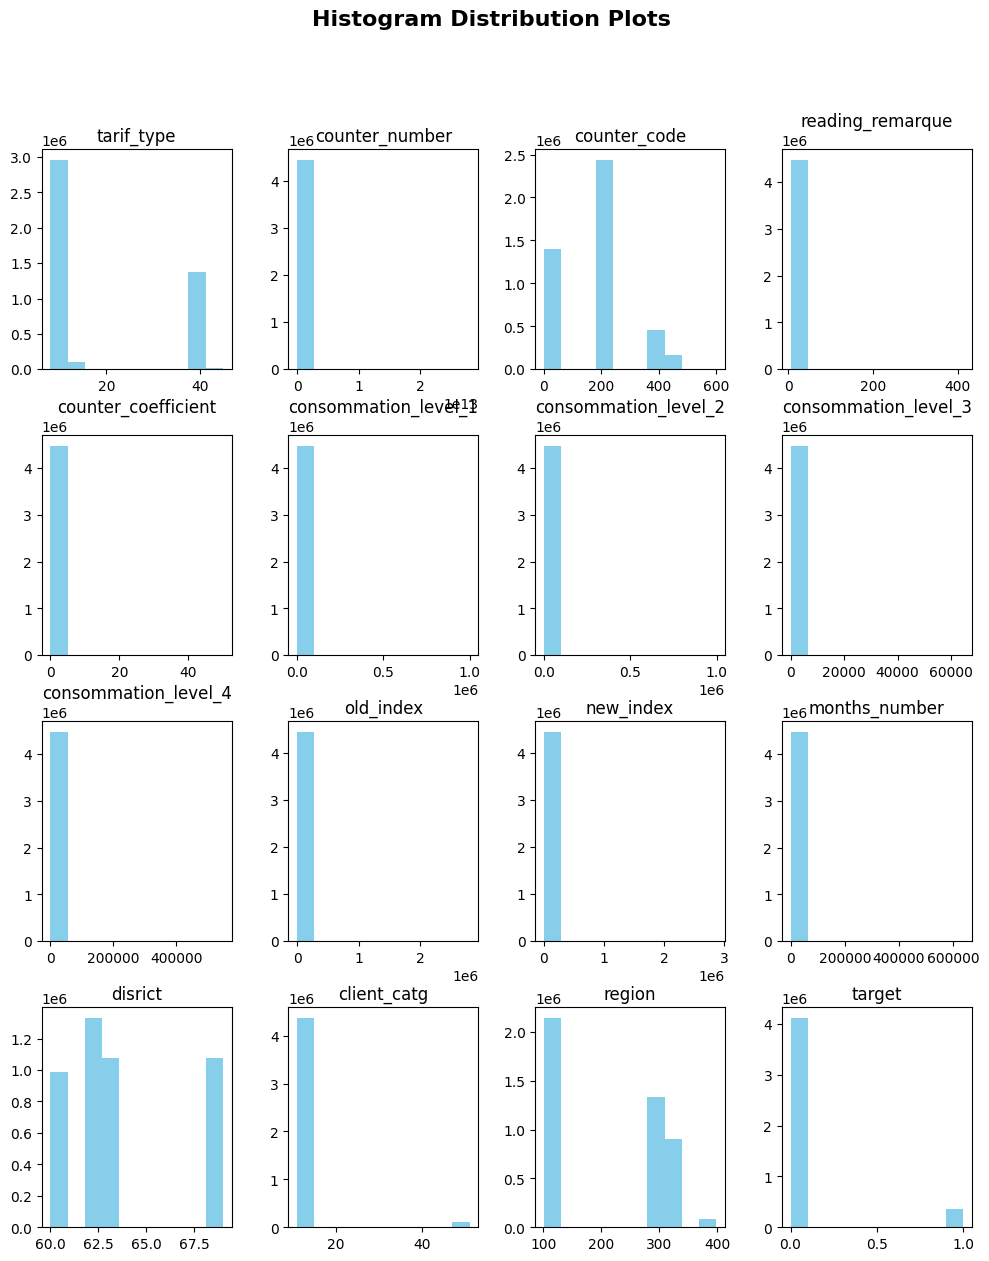

In [99]:
df.hist(figsize=(12,14),color="skyblue", grid=False)
plt.suptitle("Histogram Distribution Plots", fontsize=16, fontweight="bold")
plt.show()

 The histograms illustrate the frequency distribution of continuous numerical features. A majority of data points are concentrated around 0, indicating a negative skew in the data. To address this skewness, feature transformation techniques should be applied

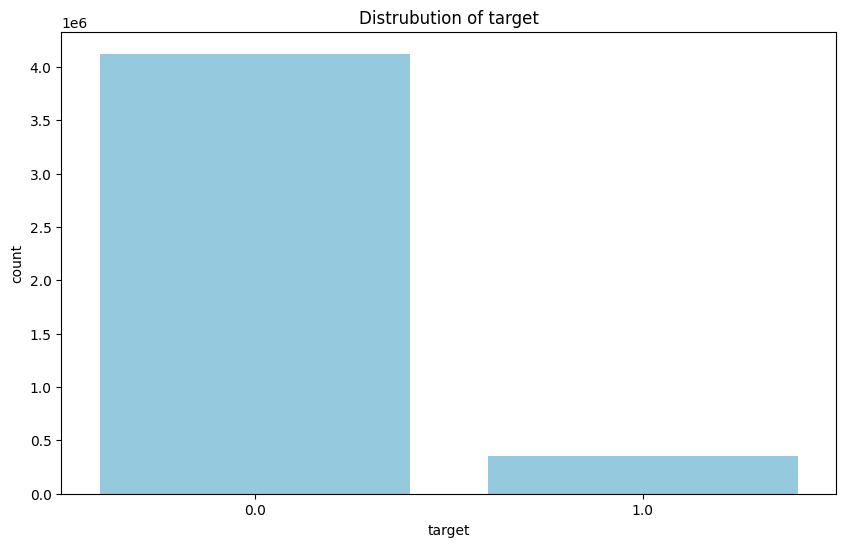

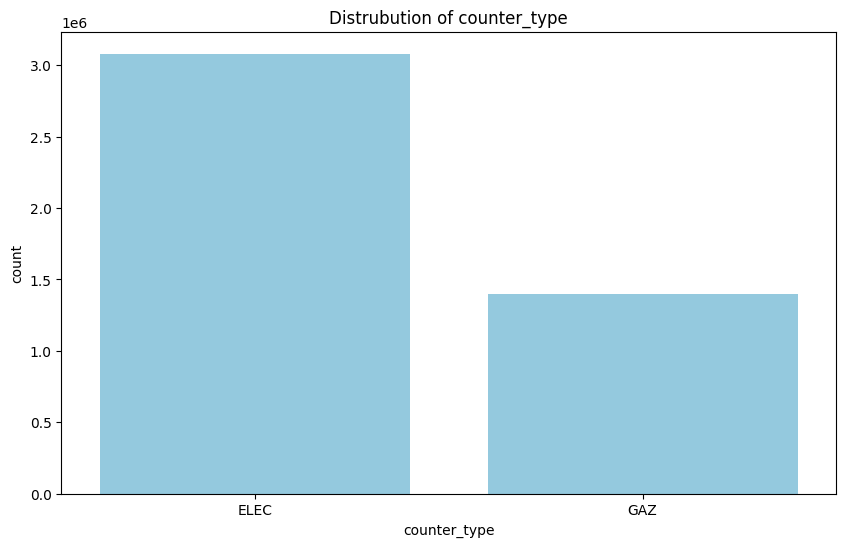

In [100]:
# Distribution of Target and Counter Type
#target
plt.figure(figsize=(10,6))
sns.countplot(data= df,x="target",color = "skyblue")
plt.title("Distrubution of target")
plt.show()
#counter_type
plt.figure(figsize=(10,6))
sns.countplot(data=df,x="counter_type",color = "skyblue")
plt.title("Distrubution of counter_type")
plt.show()

Countplots are used to visualize the frequency of each unique value within a categorical variable. In this case, we used countplots to examine the distribution of 'target' and 'counter_type'. The resulting plots show that both 'target' and 'counter_type' are positively skewed, meaning the majority of data points are concentrated towards the lower end of their value ranges with a tail extending towards higher values.

### Bi-variate Analysis

In [101]:
# Correlation Analysis
corr_df = df.corr(numeric_only=True)
corr_df

,tarif_type,counter_number,counter_code,reading_remarque,counter_coefficient,consommation_level_1,consommation_level_2,consommation_level_3,consommation_level_4,old_index,new_index,months_number,disrict,client_catg,region,target
tarif_type,1.000000,-0.050585,-0.833181,-0.053135,-0.006556,-0.185588,-0.060301,-0.087614,-0.040977,-0.194378,-0.196333,0.014203,0.068426,0.000258,-0.041803,0.013384
counter_number,-0.050585,1.000000,0.030406,0.048613,-0.000732,-0.000534,-0.003040,0.015873,0.009142,-0.027722,-0.027146,-0.000966,0.002977,0.001087,0.017088,0.028005
counter_code,-0.833181,0.030406,1.000000,0.070062,0.025231,0.210090,0.128767,0.171057,0.116415,0.326529,0.330873,-0.000656,-0.014840,0.155043,-0.027599,-0.002109
reading_remarque,-0.053135,0.048613,0.070062,1.000000,0.023982,0.090857,0.002535,0.121644,0.061261,0.082947,0.085900,0.012496,0.039314,0.062213,-0.008319,0.004769
counter_coefficient,-0.006556,-0.000732,0.025231,0.023982,1.000000,0.004384,0.030878,0.005495,0.015489,0.003380,0.003369,0.001822,-0.006744,0.060492,0.001035,-0.002853
consommation_level_1,-0.185588,-0.000534,0.210090,0.090857,0.004384,1.000000,0.067766,0.095538,0.024835,0.147225,0.156672,-0.006861,0.017279,0.045476,-0.023993,0.005515
consommation_level_2,-0.060301,-0.003040,0.128767,0.002535,0.030878,0.067766,1.000000,0.041917,0.012475,0.175242,0.183359,0.029610,-0.008321,0.124188,-0.038674,0.008421
consommation_level_3,-0.087614,0.015873,0.171057,0.121644,0.005495,0.095538,0.041917,1.000000,0.269509,0.147392,0.161778,0.090125,0.015386,0.084262,-0.044474,0.023713
consommation_level_4,-0.040977,0.009142,0.116415,0.061261,0.015489,0.024835,0.012475,0.269509,1.000000,0.279352,0.296627,-0.000571,0.009820,0.192740,-0.034948,0.013094
old_index,-0.194378,-0.027722,0.326529,0.082947,0.003380,0.147225,0.175242,0.147392,0.279352,1.000000,0.993678,-0.005734,-0.018125,0.442107,-0.073327,0.027520


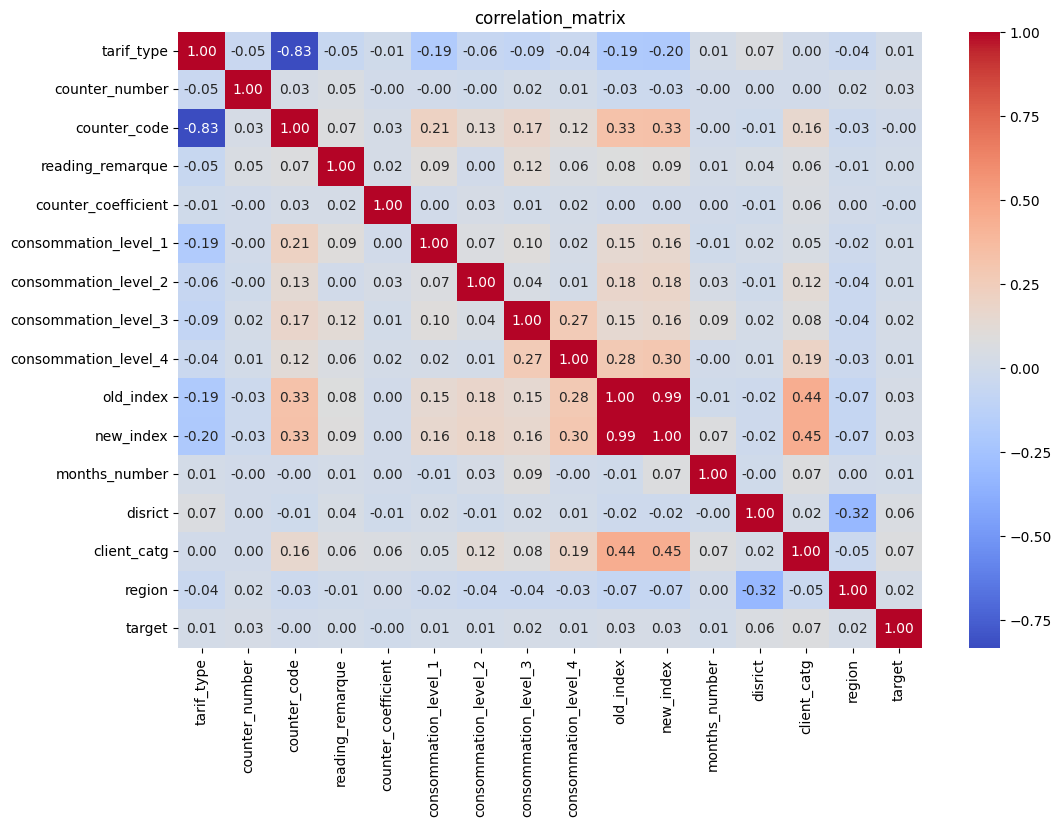

In [102]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_df,annot=True,fmt=".2f",cmap="coolwarm")
plt.title("correlation_matrix")
plt.show()

key correlations between features and  multicollinearity will remove highly correlated features plus feature engineering to combine correlated features like new and old index

In [103]:
# Counter Type vs Target Analysis
group_table = pd.crosstab(df["counter_type"],df["target"])
group_table

target,0.0,1.0
counter_type,,
ELEC,2843053,236345
GAZ,1280576,116764


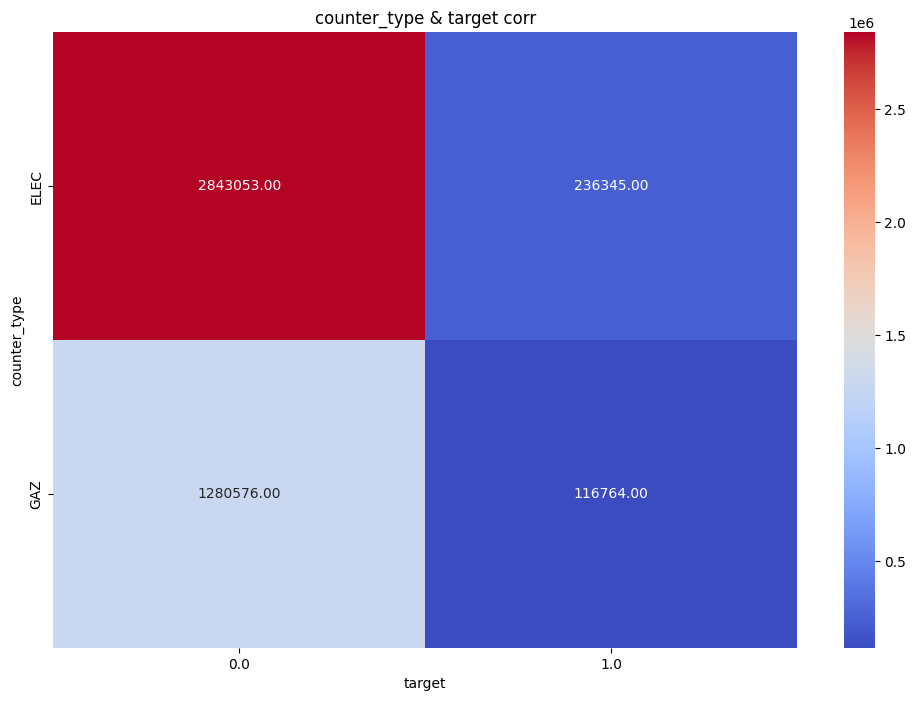

In [104]:
plt.figure(figsize=(12,8))
sns.heatmap(group_table,annot= True,cmap='coolwarm',fmt=".2f")
plt.title("counter_type & target corr")
plt.show()

Recommend to focus fraud detection efforts on high-risk counter types like elec

In [105]:
# Convert col_dates to datetime
df[["creation_date", "invoice_date"]] = df[["creation_date", "invoice_date"]].apply(
    lambda col: pd.to_datetime(col, dayfirst=True)
)

In [106]:
cor = df[["creation_date","target"]].corr()
cor

,creation_date,target
creation_date,1.000000,-0.044958
target,-0.044958,1.000000


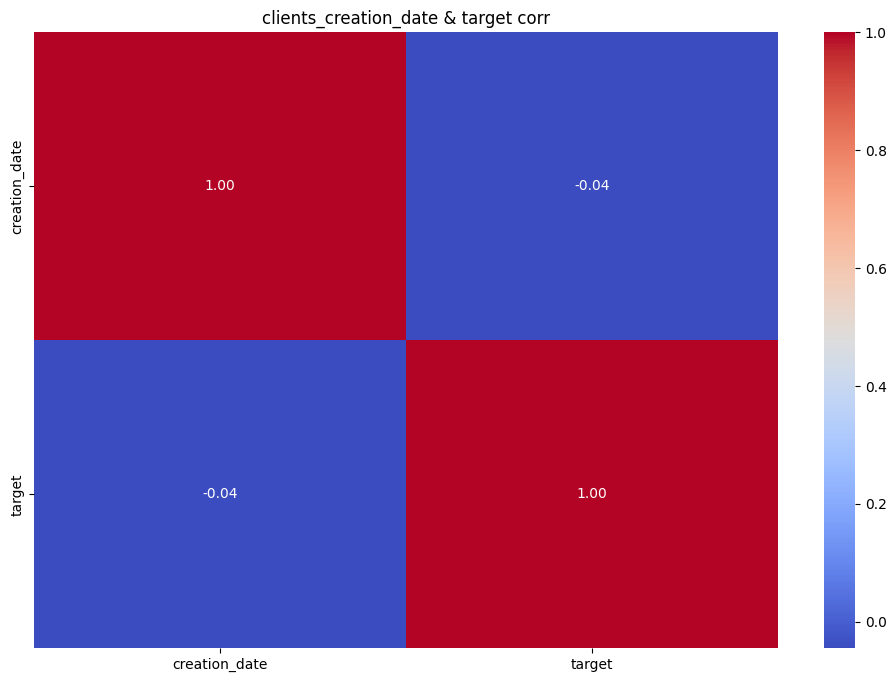

In [107]:
plt.figure(figsize=(12,8))
sns.heatmap(cor,annot= True,cmap='coolwarm',fmt=".2f")
plt.title("clients_creation_date & target corr")
plt.show()

### Multi-variate Analysis

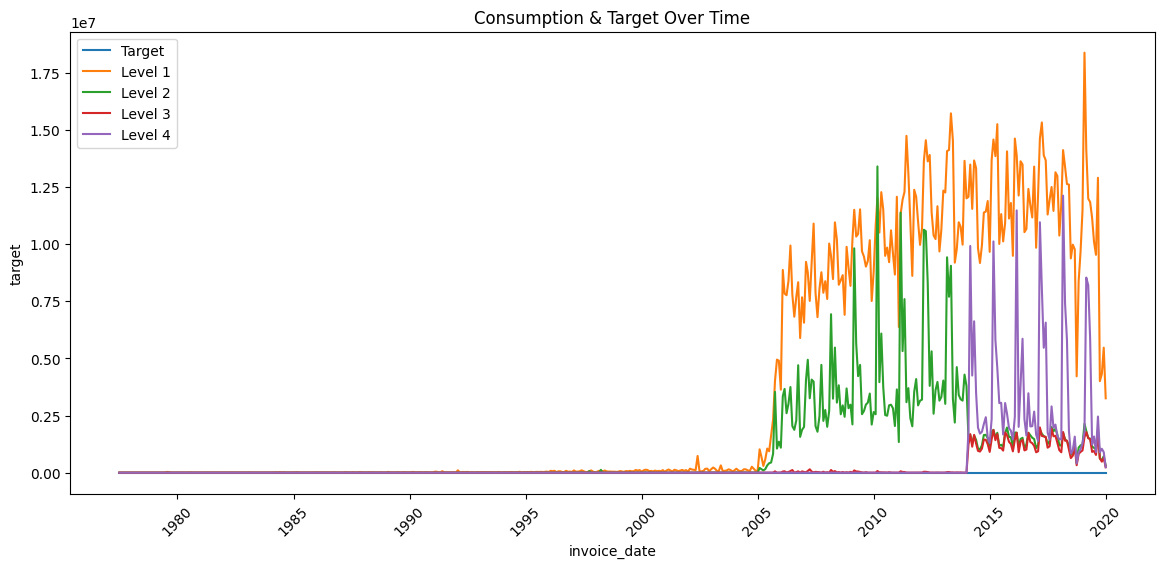

In [108]:
# Time Series Analysis
# analysis on how invoice date relates to consumption levels and target
df_time = df.set_index('invoice_date').resample('M').agg({
    'target': 'mean',
    'consommation_level_1': 'sum',
    'consommation_level_2': 'sum',
    'consommation_level_3': 'sum',
    'consommation_level_4': 'sum'
})

# Plot
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_time, x=df_time.index, y='target', label='Target')
sns.lineplot(data=df_time, x=df_time.index, y='consommation_level_1', label='Level 1')
sns.lineplot(data=df_time, x=df_time.index, y='consommation_level_2', label='Level 2')
sns.lineplot(data=df_time, x=df_time.index, y='consommation_level_3', label='Level 3')
sns.lineplot(data=df_time, x=df_time.index, y='consommation_level_4', label='Level 4')
plt.title('Consumption & Target Over Time')
plt.xticks(rotation=45)
plt.show()

level 1 consumption has the highest up trend fradulent cases with year 2019 as the high season peak while level 3 consumption has the least to non fradulent cases with a range pattern. Overall he consumption levels have shown uptrend since invoice_date 2005

<Figure size 1200x600 with 0 Axes>

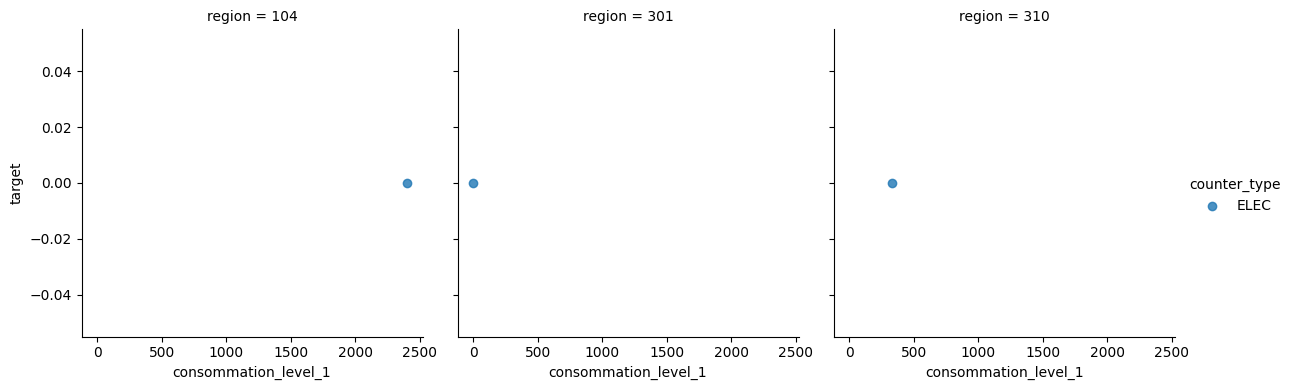

In [109]:
#Whether relationships between consumption and target vary by counter_type or region.
plt.figure(figsize=(12, 6))
sns.lmplot(
    data=df.sample(3),
    x='consommation_level_1',
    y='target',
    hue='counter_type',
    col='region',
    ci=None,
    height=4
)
plt.show()

Explained Variance Ratio: [0.1857316  0.10129173 0.08209789 0.07286929 0.06531123 0.06431925
 0.06314867 0.06116644 0.06035314]
Cumulative Variance: [0.1857316  0.28702333 0.36912123 0.44199052 0.50730175 0.571621
 0.63476967 0.69593611 0.75628925]


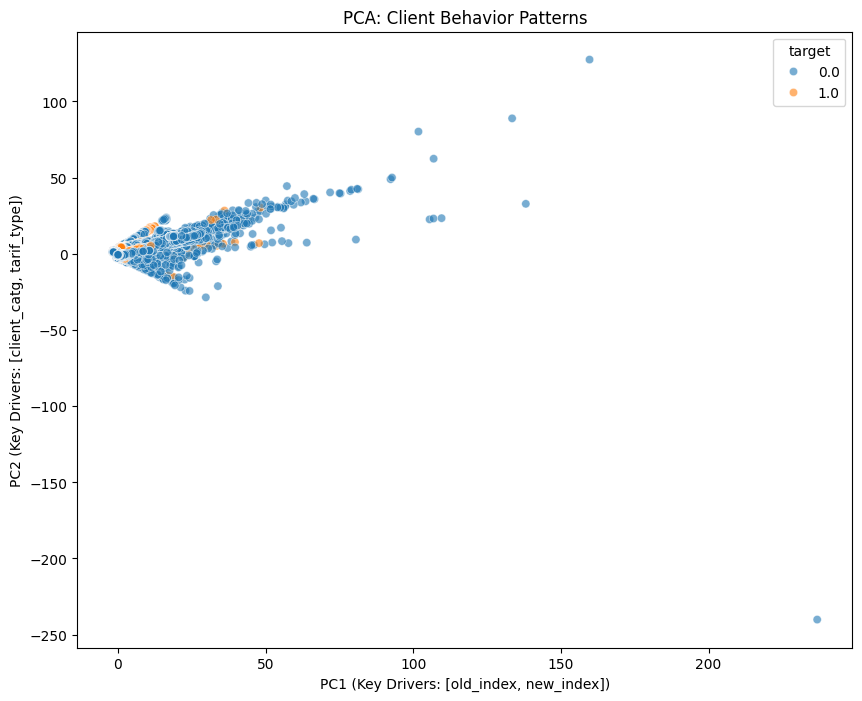

In [110]:
# PCA Analysis for Dimensionality Reduction
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[num_cols])

# PCA auto-select components for 70% variance
pca = PCA(n_components=0.70)
pca_result = pca.fit_transform(scaled_data)

# Check variance explained
print("Explained Variance Ratio:",pca.explained_variance_ratio_)
print("Cumulative Variance:", np.cumsum(pca.explained_variance_ratio_))


#plotting only the first 2 (PC1 & PC2).
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=df['target'],
    alpha=0.6
)
plt.xlabel("PC1 (Key Drivers: [old_index, new_index])")
plt.ylabel("PC2 (Key Drivers: [client_catg, tarif_type])")
plt.title("PCA: Client Behavior Patterns")
plt.legend(title="target")
plt.show()

In [111]:
#understand what each component represents.(Top drivers of PC2 )
pca_loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=num_cols
)
print(pca_loadings['PC2'].sort_values(ascending=False))

tarif_type              0.607235
client_catg             0.311180
new_index               0.236345
old_index               0.231840
consommation_level_4    0.198286
disrict                 0.185741
target                  0.085316
months_number           0.082187
consommation_level_2    0.035825
consommation_level_3    0.025460
counter_coefficient     0.009070
reading_remarque       -0.006360
counter_number         -0.092069
consommation_level_1   -0.186152
region                 -0.200507
counter_code           -0.501584
Name: PC2, dtype: float64


Focusing on most important features identified by PCA might use PCA components as features in my model

### Answer Questions


1. What is the frequency of each unique counter_type across fraud categories?

In [112]:
fraud_freq = pd.crosstab(df['counter_type'], df['target'], normalize='index') * 100
fraud_counts = pd.crosstab(df['counter_type'], df['target'])

#  plotly
fig = px.bar(fraud_freq,
             title='Fraud Frequency by Counter Type',
             labels={'counter_type': 'Counter Type', 'target': 'Fraud Status'},
             barmode='group')
fig.show()


GAZ counters show higher fraud rate compared to ELEC but overall fraud rate is relatively low across both type. Implement stricter monitoring for GAZ counters

2. Is there a relationship between consumption levels and counter_type?


3. Do seasonal variations in consumption patterns differ across counter_type and fraud categories?

In [113]:
# Create month column
df['month'] = pd.to_datetime(df['invoice_date']).dt.month

# seasonal patterns
seasonal_fraud = df.groupby(['month', 'counter_type'])['target'].mean().reset_index()

fig = px.line(seasonal_fraud,
              x='month',
              y='target',
              color='counter_type',
              title='Seasonal Fraud Patterns by Counter Type')
fig.show()

Higher fraud rates during peak consumption months (2nd month), there is different seasonal patterns for ELEC vs GAZ solution is to implement season-specific fraud detection thresholds on high peak season

## Hypothesis Testing

In [114]:
elec_fraud = df[df['counter_type'] == 'ELEC']['target']
gaz_fraud = df[df['counter_type'] == 'GAZ']['target']

# chi-square test
contingency_table = pd.crosstab(df['counter_type'], df['target'])
chi2, p_value = stats.chi2_contingency(contingency_table)[:2]

print("\nHypothesis Test Results:")
print(f"Chi-square statistic: {chi2:.2f}")
print(f"p-value: {p_value:.4f}")

# conclusion
alpha = 0.05
if p_value < alpha:
    print("\nReject null hypothesis: There is a significant difference in fraud distribution between counter types")
else:
    print("\nFail to reject null hypothesis: No significant difference in fraud distribution between counter types")



Hypothesis Test Results:
Chi-square statistic: 613.66
p-value: 0.0000

Reject null hypothesis: There is a significant difference in fraud distribution between counter types


Hypothesis test confirms relationship between counter type and fraud. p-value < 0.05 indicates significant difference

In [115]:
df['counter_statue'].value_counts()

,count
counter_statue,
0,4346960
1,73496
0,32048
5,20484
4,2706
1,540
3,258
5,144
2,32


## PRE-PROCESSING

In [126]:
#cleaning function
def preprocess_data(df):
    df['target'] = df['target'].astype(int)
    df['counter_statue'] = df['counter_statue'].astype(int)

    # Convert to datetime
    df['creation_date'] = pd.to_datetime(df['creation_date'], format='%d/%m/%Y')

    # Extract features from creation_date
    df['creation_year'] = df['creation_date'].dt.year
    df['creation_month'] = df['creation_date'].dt.month
    df['account_age'] = (pd.Timestamp.now() - df['creation_date']).dt.days

    # Drop col
    df = df.drop([
        'creation_date',
        'client_id',
        'reading_remarque'],
        axis=1
        )
    df = df.rename(
        columns={
            'disrict': 'district',
            'consommation_level_1': 'consumption_level_1',
            'consommation_level_2': 'consumption_level_2',
            'consommation_level_3': 'consumption_level_3',
            'consommation_level_4': 'consumption_level_4'
            }
        )
    return df

In [127]:
def select_features(X, y, k=10):
    # Mutual Information
    selector_mi = SelectKBest(score_func=mutual_info_classif, k=k)
    selector_mi.fit(X, y)
    mi_scores = pd.Series(selector_mi.scores_, index=X.columns)

    # Random Forest Feature Importance
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    rf_scores = pd.Series(rf.feature_importances_, index=X.columns)

    # Feature Elimination
    lr = LogisticRegression(max_iter=1000, class_weight='balanced')
    rfe = RFE(estimator=lr, n_features_to_select=k)
    rfe.fit(X, y)
    rfe_scores = pd.Series(rfe.ranking_, index=X.columns)

    # Combine score
    feature_scores = pd.DataFrame({
        'MI_Score': mi_scores,
        'RF_Score': rf_scores,
        'RFE_Rank': rfe_scores
    })

    # Selected features that appear in top k
    selected_features = feature_scores[
        ((feature_scores['MI_Score'].rank(ascending=False) <= k) &
         (feature_scores['RF_Score'].rank(ascending=False) <= k)) |
        ((feature_scores['MI_Score'].rank(ascending=False) <= k) &
         (feature_scores['RFE_Rank'] <= k)) |
        ((feature_scores['RF_Score'].rank(ascending=False) <= k) &
         (feature_scores['RFE_Rank'] <= k))
    ].index.tolist()

    return selected_features, feature_scores



In [128]:
# Split features and target
def split_data(df):
    X = df.drop('target', axis=1)
    y = df['target']
    return train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [129]:
def log_transform(x):
    return np.log(x + 1)

In [130]:
def preprocessing_pipeline(numeric_features):
    numeric_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler()),
        ('log_transform', FunctionTransformer(log_transform))
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features)
        ])

    return preprocessor